# RQ1 Output Analysis: 2020 US Elections 

Imports + load the data + pre-processing 


a. Choose 10 queries to run
    
b. Top-20 list for the 10 queries: tf-idf + cosine similarity 

c. Top-20 list for the 10 queries: word2vec + cosine similarity

e. Two dimensional scatter plot through the t-sne algorithm for tf-idf representation


### Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
import re
from nltk.corpus import stopwords
import datetime
import time
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
import math
import collections
from numpy import linalg as la
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
import nltk

### Load the data

In [2]:
with open("data/final_project.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

In [3]:
df_tweets = pd.DataFrame.from_records(data)

In [4]:
print("The total number of tweets is: {}" .format(len(df_tweets)))

The total number of tweets is: 311927


### Pre-processing 

In [5]:
'''
Description: Remove from the dataset all the tweets that are a duplicate of a tweet that we already have

Argument: dataset of all tweets

Return: dataset of unique tweets

'''
def uniqueTweets(tweets_collection):       
   
    positions_to_drop = []
    
    # Get all the tweets that are NOT a retweet
    original_tweets = []
    for pos, tweet in df_tweets.iterrows():
        if "RT" not in tweet["text"]:
            original_tweets.append(tweet["text"])
    
    # Get retweets of tweets that do not appear in the original_tweets 
    ## tweets from which we don't have the original one, only a retweet
    original_retweets = []
    for pos, tweet in df_tweets.iterrows():
        if "RT" in tweet["text"]:
            # Remove the "RT" and the mention (first chunk ended with :)
            tweet = tweet["text"].split(':')
            tweet.pop(0)
            tweet = ''.join(tweet)
            tweet = tweet.lstrip()
            if tweet not in original_retweets:
                if tweet not in original_retweets:
                    original_retweets.append(tweet)
            else:
                positions_to_drop.append(pos)

    unique_tweets = original_tweets + original_retweets
                        
    return unique_tweets, positions_to_drop

In [6]:
unique_tweets, positions_to_drop = uniqueTweets(df_tweets)
print("The total number of unique tweets is: {}" .format(len(unique_tweets)))
print("The total number of tweets to drop is: {}" .format(len(positions_to_drop)))

The total number of unique tweets is: 130912
The total number of tweets to drop is: 181015


In [7]:
df_tweets = df_tweets.drop(positions_to_drop)
print("Updated total number of tweets is: {}" .format(len(df_tweets)))

Updated total number of tweets is: 130912


In [8]:
'''
Description: Function to preprocess the tweets removing stopwords, punctiuation, emojis, RT word, 
stemming, transforming to lowercase, anonymizing the users and tokenizing.

Argument: tweet to be preprocessed - string

Return: preprocessed tweet - list of tokens

'''
def getTerms(tweet):       
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    
    #Remove punctuation
    tweet = re.sub('[.,:;!?"+-/()*..._“&]','',tweet).strip()
    
    #Remove some emojis
    tweet = re.sub('[\U00010000-\U0010ffff❤]','',tweet).strip()
    
    #Remove RT word
    tweet = re.sub('RT','',tweet).strip()

    #Remove amp html word 
    tweet = re.sub('&amp;','',tweet).strip()
    tweet = re.sub('amp','',tweet).strip()
    
    #Transform to lowercase
    tweet = tweet.lower()
       
    #Tokenize
    tweet = tweet.split()
    
    #Anonymize users (remove mentions)
    tweet = filter(lambda x:x[0]!='@', tweet)
    
    #Remove stopwords
    tweet = [word for word in tweet if word not in stops]
    
    #Stemming
    tweet = [stemming.stem(word) for word in tweet]   
    
    return tweet

### a. Select 10 queries to run 

The queries to run are: 
- Biden wins
- Trump wins
- Results elections 
- President Biden
- President Trump
- US elections
- Elections 2020
- Votes elections 
- Biden votes 
- Trump votes 

### b. Top-20 list for the 10 queries: tf-idf + cosine similarity 

##### Create the tf-idf index

In [9]:
'''
Description: Implementation of inverted index and computation of tf, df and idf

Argument: collection of tweets and the number of tweets

Return: inverted index, tf (normalized term frequency for each term in each document), 
df (number of documents each term appear in), idf (inverse document frequency of each term)

'''
def create_index_tfidf(tweets_collection, numTweets):
    
    index=defaultdict(list) 
    
    tf=defaultdict(list) # term frequencies of terms in tweets (tweets in the same order as in the main index)
    df=defaultdict(int) # tweet frequencies of terms in the corpus
    idf=defaultdict(float)
    
    
    for pos, tweet in tweets_collection.iterrows():
        #Get the preprocessed terms of the tweet text
        ## Get the full text if possible and the partial one if extended tweet (that contains the full text) is not present
        retweeted_status = tweets_collection["retweeted_status"][pos]
        if isinstance(retweeted_status,dict):
            if "extended_tweet" in retweeted_status:
                extended_tweet = retweeted_status["extended_tweet"]
                text = extended_tweet["full_text"]
            else:
                text = tweets_collection["text"][pos]
        else:
            text = tweets_collection["text"][pos]
        
        terms = getTerms(text)
        
        #Get the tweet id to identify the tweet
        tweet_id = df_tweets["id"][pos]
        
        
        #INVERTED INDEX
        #Construct the inverted index with the terms extracted and the ids of the tweets
        termdictPage={}
        for position, term in enumerate(terms): 
            try:
                # if term already in index for current tweet, append position to corresponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key,  initialize the array of positions and add the position
                termdictPage[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in python)
            
        # merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
    
    
        #COMPUTE TF, DF AND IDF  
   
        # Compute the denominator to normalize term frequencies acording to the length of the tweet 
            ## Apply the Euclidean norm - same for all terms in a tweet
        norm=0
        for term, posting in termdictPage.items(): 
            norm+=len(posting[1])**2 # posting[1] is the frequency of term
        norm=math.sqrt(norm)        

        # Compute tf in the current tweet: number of times the term appears in the tweet (normalized)
        # Compute df: increase the term counter each time term appears in a tweet
        for term, posting in termdictPage.items():   
            tf[term].append(np.round(len(posting[1])/norm,4)) # append the term frequency in the tweet in the tf dictionary
            df[term]+=1  
                    
    # Compute idf 
    for term in df:
        idf[term] = np.round(np.log(float(numTweets/df[term])),4)
            
    return index, tf, df, idf

In [10]:
start_time = time.time()
numTweets = len(df_tweets)
index, tf, df, idf = create_index_tfidf(df_tweets, numTweets)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 300.73 seconds


##### Implement the ranking based on tf-idf score

In [11]:
'''
Description: Ranking of the results based on the tf-idf weights and their cosine similarity.

Argument: list of the query terms, list of documents to rank matching the query, index, idf and tf

Return: List of ranked documents

'''
def rankDocuments(query_terms, tweets, index, idf, tf):
    
    # GENERATE THE QUERY AND TWEET VECTORS BASED ON TF-IDF SCORES

    # - Initialize the vectors 
    
    ## Initialize the query vector with 0s (as many as query terms in the query)
    queryVector=[0]*len(query_terms)   

    ## Initialize the tweet vector with a default dict that takes value [0]*len(query_terms) as default 
    ## for each non-existing key that we call. This is because we are only interested in the terms of the
    ## tweets vector that correspond to the query terms (other will became 0 when multiplied to queryVector)
    tweetVectors=defaultdict(lambda: [0]*len(query_terms))
        
    # - Compute the norm for the query terms frequency
    query_terms_count = collections.Counter(query_terms) # frequency of each term in query (key is the word and value its frequency)
    query_norm = la.norm(list(query_terms_count.values())) # norm for query
    
    # - Generate query and tweet vectors
    for termIndex, term in enumerate(query_terms): #termIndex is the index of the term in the query
        # if the term is not present in the index do not interact with that term but continue with the following ones
        if term not in index:
            continue
                    
        # Compute tf*idf for query vector (tf normalized as in tweets)
        queryVector[termIndex] = tf[term][termIndex]/query_norm * idf[term] 
        
        # Compute tf*idf for tweetsVectors 
        for tweetIndex, (tweet, postings) in enumerate(index[term]):        
            if tweet in tweets: # tweets parameter contains only tweets matching the query
                tweetVectors[tweet][termIndex] = tf[term][tweetIndex] * idf[term] 
                    
    # COMPUTE COSINE SIMILARITY 
                    
    # Compute cosine similarity (dot product since for normalized vectors it corresponds to the cosine similarity)
    tweetScores=[ [np.dot(curTweetVec, queryVector), tweet] for tweet, curTweetVec in tweetVectors.items() ]
    
    
    # RANK DOCUMENTS BASED ON COSINE SIMILARITY
    
    #Sort the tweets in descending order based on the cosine similarity 
    tweetScores.sort(reverse=True) 
    resultTweets=[x[1] for x in tweetScores]
    
    if len(resultTweets) == 0:
        print("\nNo results found, try again\n")
        query = input()
        tweets = search_tf_idf(query, index)    

    return resultTweets

##### Return ranked documents when inserting a query based on tf-idf cosine similarity

In [12]:
'''
Description: Usage of inverted index with a query also using the ranking of the tweets

Argument: the query entered by the user and the index previously generated

Return: list of tweets that contain all the query terms ranked by tf-idf 

'''
def search_tf_idf(query, index):

    query=getTerms(query)
    tweets=set()
    
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termTweets=[posting[0] for posting in index[term]]
            # Perform AND operation since we want tweets containing all the terms in the query 
            if len(tweets) == 0: #if the set is empty for the first iteration
                tweets |= set(termTweets)
            else:
                tweets &= set(termTweets)
        except:
            #term is not in index
            pass
    tweets=list(tweets)
    ranked_tweets = rankDocuments(query, tweets, index, idf, tf)   
    return ranked_tweets

In [13]:
'''
Description: Print the top tweets ranked

Argument: query input

'''
def queryTweets(query, index, top = 20):
    ranked_tweets = search_tf_idf(query, index)    

    print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_tweets)))
    position = 0
    for tweet in ranked_tweets[:top]:   
        user = {}
        entities = {}
        urls = []
        retweeted_status = {}

        print("\n---------------\n")
        #Get row index to extract the desired information
        position = df_tweets[df_tweets['id'] == tweet].index[0]

        date = df_tweets["created_at"][position]

        retweeted_status = df_tweets["retweeted_status"][position]
        if isinstance(retweeted_status,dict):
            if "extended_tweet" in retweeted_status:
                extended_tweet = retweeted_status["extended_tweet"]
                tweet_text = extended_tweet["full_text"]
                entities = extended_tweet["entities"]
                hashtags = entities["hashtags"] 
                if "media" in entities: 
                    media = entities["media"]
                    url = media[0]["expanded_url"]
                else:
                    entitites = retweeted_status["entities"]
                    urls = entities["urls"]
                    if(urls != []):
                        url = urls[0]["expanded_url"]
                    else:
                        url = []
            else:
                tweet_text = df_tweets["text"][position]
                entities = df_tweets["entities"][position]            
                hashtags = entities["hashtags"]
                urls = entities["urls"]
                if(urls != []):
                    url = urls[0]["expanded_url"]
                else:
                    url = []

            user = retweeted_status["user"]
            username = user["screen_name"]

            likes = retweeted_status["favorite_count"]
            retweets = retweeted_status["retweet_count"]        

        else:
            tweet_text = df_tweets["text"][position]
            user = df_tweets["user"][position]
            username = user["screen_name"]
            entities = df_tweets["entities"][position]
            hashtags = entities["hashtags"]
            likes = df_tweets["favorite_count"][position]
            retweets = df_tweets["retweet_count"][position]
            urls = entities["urls"]
            if(urls != []):
                url = urls[0]["expanded_url"]
            else:
                url = [] 

        # print all the desired information
        print("Tweet_id: {}".format(tweet))
        print("\n Tweet: {}".format(tweet_text))
        print("\n Username: {}".format(username))
        print("\n Date: {}".format(date))
        print("\n Hashtags: {}".format(hashtags))
        print("\n Likes: {}".format(likes))
        print("\n Retweets: {}".format(retweets))
        print("\n Url: {}".format(url))

In [14]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

biden wins

Top 20 results out of 1243 for the seached query:


---------------

Tweet_id: 1336041388018987014

 Tweet: @thehill Not win Biden did not win

 Username: MSREDMAMA1

 Date: Mon Dec 07 20:14:24 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336041749060390925

 Tweet: RT @VET_TYHALL: @GeoffRBennett @DemocratsUp @PeteWilliamsNBC Joe Biden wins again!
WINNING 🇺🇸

 Username: VET_TYHALL

 Date: Mon Dec 07 20:15:50 +0000 2020

 Hashtags: []

 Likes: 20

 Retweets: 2

 Url: []

---------------

Tweet_id: 1336305260911087616

 Tweet: Biden has won again. All the winning!

 Username: nbencesolutions

 Date: Tue Dec 08 13:42:56 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336299955926032385

 Tweet: And Biden wins again! 😀😀😀

 Username: eileengo1

 Date: Tue Dec 08 13:21:51 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 133629887575413

##### Run the 10 queries

In [29]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Biden wins

Top 20 results out of 1243 for the seached query:


---------------

Tweet_id: 1336041388018987014

 Tweet: @thehill Not win Biden did not win

 Username: MSREDMAMA1

 Date: Mon Dec 07 20:14:24 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336041749060390925

 Tweet: RT @VET_TYHALL: @GeoffRBennett @DemocratsUp @PeteWilliamsNBC Joe Biden wins again!
WINNING 🇺🇸

 Username: VET_TYHALL

 Date: Mon Dec 07 20:15:50 +0000 2020

 Hashtags: []

 Likes: 20

 Retweets: 2

 Url: []

---------------

Tweet_id: 1336305260911087616

 Tweet: Biden has won again. All the winning!

 Username: nbencesolutions

 Date: Tue Dec 08 13:42:56 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336299955926032385

 Tweet: And Biden wins again! 😀😀😀

 Username: eileengo1

 Date: Tue Dec 08 13:21:51 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 133629887575413

In [30]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Trump wins

Top 20 results out of 1685 for the seached query:


---------------

Tweet_id: 1330463302649081863

 Tweet: @LLinWood @SidneyPowell1 @RudyGiuliani @realDonaldTrump Trump is Winning Winning Winning

 Username: trinitychooster

 Date: Sun Nov 22 10:49:04 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330455180173848579

 Tweet: @newsmax @bennyjohnson Trump win win win....

 Username: RehulinaGinti13

 Date: Sun Nov 22 10:16:48 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330455432171827208

 Tweet: RT @RandyRRQuaid: 100% support! The count continues and Trump is Winning Winning WINNING!!!

 Username: RandyRRQuaid

 Date: Sun Nov 22 10:17:48 +0000 2020

 Hashtags: []

 Likes: 5837

 Retweets: 1198

 Url: []

---------------

Tweet_id: 1336042384325488646

 Tweet: @LisaMarieBoothe Did Biden win? No.
Did Trump win? Yes.

 Username: blueANDblack4me

 Date: Mon Dec 07 20:18:

In [26]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Results elections

Top 20 results out of 1277 for the seached query:


---------------

Tweet_id: 1336037659567861761

 Tweet: @LindseyGrahamSC So if they were to "audit" an election result that Trump has now lost three times, can we have both your and McConnell's election results recounted and audited as well? Your results are a lot more suspect and sketchy than most others. https://t.co/sHSfuKixw1

 Username: GypsySpirit1946

 Date: Mon Dec 07 19:59:35 +0000 2020

 Hashtags: []

 Likes: 9

 Retweets: 4

 Url: https://twitter.com/GypsySpirit1946/status/1336025618069250050/photo/1

---------------

Tweet_id: 1336039873296302080

 Tweet: @burtjonesforga @realDonaldTrump The results of our free and fair election resulted in President Trump being SLAUGHTERED !!! #BiggestLoser https://t.co/iHi4hkbvcX

 Username: KenEmpie

 Date: Mon Dec 07 20:08:22 +0000 2020

 Hashtags: [{'text': 'BiggestLoser', 'indices': [125, 138]}]

 Likes: 17

 Retweets: 2

 Url: https://twitter.c

In [27]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

President Biden

Top 20 results out of 2310 for the seached query:


---------------

Tweet_id: 1336304639076163584

 Tweet: Biden is not our President

 Username: Stevens_USAF

 Date: Tue Dec 08 13:40:27 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336303181576302594

 Tweet: @Kica333 Biden is my President

 Username: carterknox10

 Date: Tue Dec 08 13:34:40 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336303007718260736

 Tweet: @Gigi_MCal @NorahODonnell Biden is not President.

 Username: ScoooterScott

 Date: Tue Dec 08 13:33:59 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336296579398049792

 Tweet: @DonaldJTrumpJr Biden is our President

 Username: SpainA7mad

 Date: Tue Dec 08 13:08:26 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336295216815411200

 Tweet: RT @katiedidanddid: @mmpa

In [28]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

President Trump

Top 20 results out of 6151 for the seached query:


---------------

Tweet_id: 1330457613411241984

 Tweet: Sunday, and president TRUMP is THE PRESIDENT.

 Username: Conservative964

 Date: Sun Nov 22 10:26:28 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330454302142443521

 Tweet: President Trump Is My Favorite President !

 Username: Holmes23Carolyn

 Date: Sun Nov 22 10:13:18 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336037262627196928

 Tweet: RT @lavist1: Trump won.  He’s the President. @realDonaldTrump @POTUS 

We won’t accept a fraud president. You are the President.

 Username: lavist1

 Date: Mon Dec 07 19:58:00 +0000 2020

 Hashtags: []

 Likes: 17

 Retweets: 7

 Url: []

---------------

Tweet_id: 1336305591644512257

 Tweet: @LionelMedia President Trump continuing as our 45th President

 Username: SmittenMitten2

 Date: Tue Dec 08 13:44:15 +0000

In [31]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

US elections

Top 20 results out of 762 for the seached query:


---------------

Tweet_id: 1330459363987910658

 Tweet: @MunyiriWaithira @USAmbKenya @lulufmradio US election was free, fair and credible.

US institutions are independent… https://t.co/refJyaW65J

 Username: BenPensador

 Date: Sun Nov 22 10:33:25 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: https://twitter.com/i/web/status/1330459363987910658

---------------

Tweet_id: 1336040271784525824

 Tweet: @nkotbfanjen @Locktar_Bismar @cenkuygur @realDonaldTrump Why is it that in the US, there has not been election trou… https://t.co/Z1yi1eXeDI

 Username: BroMark13

 Date: Mon Dec 07 20:09:57 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: https://twitter.com/i/web/status/1336040271784525824

---------------

Tweet_id: 1330457733783572483

 Tweet: Haha, the US election just keeps on giving... 🤣

 Username: robandrewjones

 Date: Sun Nov 22 10:26:57 +0000 2020

 Hashtags: []

 Likes: 0

In [32]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Elections 2020

Top 20 results out of 546 for the seached query:


---------------

Tweet_id: 1336305096192212992

 Tweet: #Trump election 2020 https://t.co/aG2MDCb8yx

 Username: MeeraVaithiya

 Date: Tue Dec 08 13:42:16 +0000 2020

 Hashtags: [{'text': 'Trump', 'indices': [0, 6]}]

 Likes: 0

 Retweets: 0

 Url: https://youtu.be/FLa9jZfiYlI

---------------

Tweet_id: 1336039154044514305

 Tweet: @XWescott @PalmerReport Trump won the 2020 election in 2016

 Username: DavOakMus

 Date: Mon Dec 07 20:05:31 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330461256218783744

 Tweet: Election 2020 going to the Courts.

 Username: Trokani1

 Date: Sun Nov 22 10:40:56 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330459317825257473

 Tweet: RT @MediaSequitur: Trump won the 2020 Election.
ⓘ 𝗧𝗵𝗶𝘀 𝗰𝗹𝗮𝗶𝗺 𝗶𝘀 𝘁𝗿𝘂𝗲

 Username: MediaSequitur

 Date: Sun Nov 22 10:33:14 +0000 2020

 Hashtags: []

In [33]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Votes elections

Top 20 results out of 959 for the seached query:


---------------

Tweet_id: 1336044193857331202

 Tweet: Georgia republicans : a vote in this rigged election is a vote for Nancy pelosi! If you vote the libs win! Don’t le… https://t.co/ffFX3SZkfS

 Username: BwCogs

 Date: Mon Dec 07 20:25:32 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: https://twitter.com/i/web/status/1336044193857331202

---------------

Tweet_id: 1330462669380448267

 Tweet: Hey, it's a SCAM election. 

Black vote (~25%), Latino vote, every other vote went for Trump.

They fixed it to 90%… https://t.co/X0RpnsHffw

 Username: stopthestealll

 Date: Sun Nov 22 10:46:33 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: https://twitter.com/i/web/status/1330462669380448267

---------------

Tweet_id: 1336046950093819906

 Tweet: Dude, we just voted. Participating in an election, exercising our right to vote does not ruin an election, it's how… https://t.co/pSQugW

In [34]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Biden votes

Top 20 results out of 2460 for the seached query:


---------------

Tweet_id: 1336304245369229312

 Tweet: This is what you voted for a vote for Biden was a vote for CHINA

 Username: LadyFre19292445

 Date: Tue Dec 08 13:38:54 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336304491394703360

 Tweet: @Kica333 Did you vote for Biden?

 Username: Lady83Warrior

 Date: Tue Dec 08 13:39:52 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336294949260849152

 Tweet: 💀 voted Biden

 Username: Lucia196242

 Date: Tue Dec 08 13:01:57 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336045167552425984

 Tweet: Then you shouldn't have voted for Biden.

 Username: arks_remarks

 Date: Mon Dec 07 20:29:25 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336042299873169408

 Tweet: @washingtonpost I v

In [35]:
print("Insert your query:\n")
query = input()
queryTweets(query, index)

Insert your query:

Trump votes

Top 20 results out of 3491 for the seached query:


---------------

Tweet_id: 1330437109937790977

 Tweet: RT @reubing: A Biden vote is 1.25 of a vote and a Trump vote is 0.75 votes.

~Sidney Powell

 Username: reubing

 Date: Sun Nov 22 09:04:59 +0000 2020

 Hashtags: []

 Likes: 835

 Retweets: 424

 Url: []

---------------

Tweet_id: 1336296277944852486

 Tweet: @EzraKCohen1 Because We the People voted for Trump,  the voting machines voted for Biden

 Username: SperlAnn

 Date: Tue Dec 08 13:07:14 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336043091623555077

 Tweet: Some of you are worried that the voting machines changed Trump votes to Biden votes. I'm here to tell you:

Trans👏votes 👏are👏 votes👏 https://t.co/I7NKd0ZH4A

 Username: wokal_distance

 Date: Mon Dec 07 20:21:10 +0000 2020

 Hashtags: []

 Likes: 237

 Retweets: 26

 Url: https://twitter.com/ConceptualJames/status/1336002704137707525

----

### c. Top-20 list for the 10 queries: word2vec + cosine similarity

#####  Get the corpus in the format needed for word2vec funcion

In [38]:
# Get a list of lists with a list of all the tokens for each tweet - input of the Word2Vec function

corpus = []

for pos, tweet in df_tweets.iterrows():
        #Get the preprocessed terms of the tweet text
        ## Get the full text if possible and the partial one if extended tweet (that contains the full text) is not present
        retweeted_status = df_tweets["retweeted_status"][pos]
        if isinstance(retweeted_status,dict):
            if "extended_tweet" in retweeted_status:
                extended_tweet = retweeted_status["extended_tweet"]
                text = extended_tweet["full_text"]
            else:
                text = df_tweets["text"][pos]
        else:
            text = df_tweets["text"][pos]
        
        terms = getTerms(text)
        
        corpus.append(terms)       
        

In [40]:
print(corpus[:5])

[['biden', 'surpass', '6', 'million', 'popular', 'vote', 'victori', 'margin', 'approach', '80', 'million', 'vote', 'elector', 'colleg', '306236', 'especi', 'incumb', 'blowout', 'decis', 'close', 'race', 'american', 'peopl', 'need', 'hear', 'truth'], ['cnn', 'guest', 'report', 'trump', 'lost', '33', 'case', 'court', 'fals', 'lost', '34'], ['break', 'curfew', 'sure', 'tear', 'ga', 'rubber', 'bullet', 'soon', 'follow'], ['presid', 'trump', 'done', 'mani', 'great', 'thing', 'biggest', 'tax', 'regul', 'cut', 'histori', 'space', 'forc', 'rebuild', 'militari', 'fix', 'va', 'wall', 'perhap', 'import', 'expos', 'massiv', 'corrupt', 'elector', 'process”'], ['trump', 'love', 'america', 'much', 'work', 'harder', 'anyon', 'imagineh', 'gave', "billionaire'", 'life', 'american', 'peoplesay', 'someth', 'trump', 'see']]


#####  Create the word2vec model 

In [41]:
word2vec = Word2Vec(sentences=corpus, size=100, min_count = 1)

In [42]:
print(word2vec)

Word2Vec(vocab=136444, size=100, alpha=0.025)


In [43]:
print(word2vec.wv['biden'])

[-2.18286648e-01 -1.92483783e+00  8.21998358e-01 -4.32855397e-01
  1.77134836e+00  8.69754374e-01  2.34858274e+00 -8.61915410e-01
  1.78735971e+00 -1.47152507e+00 -1.16978121e+00 -1.19248080e+00
 -7.12708831e-01  1.84387398e+00 -1.51328027e+00  2.11115980e+00
  2.00807834e+00  3.74655932e-01  1.26851201e+00 -5.63594878e-01
 -3.67663473e-01  1.73978937e+00  1.37125993e+00  1.62038875e+00
  9.31757689e-01 -2.96828508e-01  1.07548285e+00  2.35096693e+00
  9.67977822e-01 -1.61033833e+00  8.23675156e-01  7.75605083e-01
 -1.22915161e+00  2.62803525e-01  2.10382044e-01 -1.44529927e+00
  1.64710671e-01 -2.08417416e+00  2.73435682e-01 -5.09599566e-01
  1.35948431e+00  1.00730288e+00 -5.23020685e-01  1.16063643e+00
  7.70998478e-01 -9.64516699e-01  7.46455371e-01 -9.84267712e-01
  1.82059968e+00  1.90554559e-03 -6.98491693e-01 -6.01567686e-01
 -5.27196825e-01 -5.76342165e-01  1.94007337e+00 -1.38365912e+00
  3.96695662e+00 -1.20009196e+00 -8.50785851e-01 -2.18886416e-02
  1.25377285e+00 -1.77483

In [44]:
word2vec.wv.most_similar('trump')

[('instead', 0.7808285355567932),
 ("donald'", 0.7785124182701111),
 ('trump’', 0.769189715385437),
 ('trump…', 0.7557237148284912),
 ('preemptiv', 0.7514262199401855),
 ("trump'", 0.7416019439697266),
 ('#kempforprison', 0.7236265540122986),
 ('togeth', 0.7218248844146729),
 ('furious', 0.718829333782196),
 ('also', 0.7166080474853516)]

##### Create the tweet2vec index

In [49]:
'''
Description: Implementation of inverted index and computation of tweet2vec for each tweet in the collection

Argument: collection of tweets and the number of tweets

Return: inverted index and tweet2vec, which is the vector representation of the tweet based on the word2vec representation 

'''
def create_index_tweet2vec(tweets_collection, numTweets):
    
    index=defaultdict(list) 
    
    tweet2vec=defaultdict(array)
    
    
    for pos, tweet in tweets_collection.iterrows():
        #Get the preprocessed terms of the tweet text
        ## Get the full text if possible and the partial one if extended tweet (that contains the full text) is not present
        retweeted_status = tweets_collection["retweeted_status"][pos]
        if isinstance(retweeted_status,dict):
            if "extended_tweet" in retweeted_status:
                extended_tweet = retweeted_status["extended_tweet"]
                text = extended_tweet["full_text"]
            else:
                text = tweets_collection["text"][pos]
        else:
            text = tweets_collection["text"][pos]
        
        terms = getTerms(text)
        
        #Get the tweet id to identify the tweet
        tweet_id = df_tweets["id"][pos]
        
        
        #INVERTED INDEX
        #Construct the inverted index with the terms extracted and the ids of the tweets
        termdictPage={}
        for position, term in enumerate(terms): 
            try:
                # if term already in index for current tweet, append position to corresponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key,  initialize the array of positions and add the position
                termdictPage[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in python)
            
        # merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
    
    
        #COMPUTE TWEET2VEC
        ## To compute the tweet2vec we need to average the vectors of all the words contained in the tweet 
        ### The words are in the terms vector that we have just created
        
        sum_array = np.zeros(100)
        
        for term in terms:
            sum_array += word2vec.wv[term]

        avg_array = sum_array/len(terms) 
        
        tweet2vec[tweet_id] = avg_array
                 
    return index, tweet2vec

In [50]:
start_time = time.time()
numTweets = len(df_tweets)
index, tweet2vec = create_index_tweet2vec(df_tweets, numTweets)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

<ipython-input-49-ddf4c4a4da56>:60: RuntimeWarning: invalid value encountered in true_divide
  avg_array = sum_array/len(terms)


Total time to create the index: 576.61 seconds


In [51]:
index['biden']

[[1330436137874288643, array('I', [0])],
 [1330436139816267776, array('I', [6, 13])],
 [1330436141254725632, array('I', [3])],
 [1330436142991368195, array('I', [15, 20])],
 [1330436145436626946, array('I', [2])],
 [1330436147135188993, array('I', [9])],
 [1330436148125163521, array('I', [6])],
 [1330436149123411968, array('I', [5])],
 [1330436149945491458, array('I', [2])],
 [1330436151296057344, array('I', [3])],
 [1330436151530893317, array('I', [4, 16])],
 [1330436152126533634, array('I', [18])],
 [1330436152684376069, array('I', [13])],
 [1330436152982171650, array('I', [17])],
 [1330436153325993984, array('I', [8])],
 [1330436157939781639, array('I', [0])],
 [1330436158145273856, array('I', [9])],
 [1330436160334802944, array('I', [10])],
 [1330436165476999177, array('I', [18])],
 [1330436165770436608, array('I', [10])],
 [1330436165774827523, array('I', [5])],
 [1330436166332542976, array('I', [1])],
 [1330436167263801344, array('I', [3])],
 [1330436167704174593, array('I', [1])

In [52]:
tweet2vec

defaultdict(array.array,
            {1330436137874288643: array([-0.65387129, -1.07768969, -0.46909435,  0.04463248, -0.15457561,
                     0.38943305,  0.78290167, -0.17361055,  1.0080461 , -1.02325759,
                    -0.26831928,  0.46933137, -0.96249143,  1.11994066, -1.71192399,
                     0.8889021 , -0.0695474 ,  0.65460248,  0.08893112,  0.44649721,
                     0.22359865,  0.81231796,  0.46939358, -0.19529268,  1.26264053,
                    -0.02521929,  0.68049572,  0.46068803,  0.18218374, -0.27807306,
                     0.34395678,  1.21602988, -0.68026538,  0.12953383,  0.88351922,
                    -0.55176889, -0.71290849, -0.65172169,  0.53993835, -0.47112509,
                     1.94598526, -0.08865529,  0.29646386,  0.08035486, -0.66625737,
                    -0.51920272, -0.03680449, -1.02287001,  0.34411859, -0.13346596,
                    -0.11761101, -0.05960723, -0.11053082, -0.12479488,  0.58772597,
                   

##### Return ranked documents when inserting a query based on tweet2vec cosine similarity

In [54]:
'''
Description: Ranking of the results based on the word2vec representation and their cosine similarity.

Argument: list of the query terms, list of documents to rank matching the query, index, tweet2vec

Return: List of ranked documents

'''
def rankDocuments_word2vec(query_terms, tweets, word2vec, tweet2vec):
    
    # GENERATE THE QUERY AND TWEET VECTORS 

    # - Initialize the vectors 
    
    ## Initialize the query vector with 0s (as many as query terms in the query)
    queryVector=[0]*100   

    ## Initialize the tweet vector with a default dict that takes value [0]*len(query_terms) as default 
    ## for each non-existing key that we call. This is because we are only interested in the terms of the
    ## tweets vector that correspond to the query terms (other will became 0 when multiplied to queryVector)
    tweetVectors=defaultdict(array)
      
        
    
    # Generate vector for the query word2vec representation - average word2vec representation of all query words
    sum_array = np.zeros(100)
    for term in query_terms:
        sum_array += word2vec.wv[term]
    queryVector = sum_array/len(terms)
    
    for tweet in tweets: # tweet is the tweet id
        tweetVectors[tweet] = tweet2vec[tweet]
                       
    
    # COMPUTE COSINE SIMILARITY 
                    
    # Compute cosine similarity (dot product since for normalized vectors it corresponds to the cosine similarity)
    tweetScores=[ [np.dot(curTweetVec, queryVector), tweet] for tweet, curTweetVec in tweetVectors.items() ]
    
    
    # RANK DOCUMENTS BASED ON COSINE SIMILARITY
    
    #Sort the tweets in descending order based on the cosine similarity 
    tweetScores.sort(reverse=True) 
    resultTweets=[x[1] for x in tweetScores]
    
    if len(resultTweets) == 0:
        print("\nNo results found, try again\n")
        query = input()
        tweets = search_word2vec(query, index)    

    return resultTweets

In [55]:
'''
Description: Usage of inverted index with a query also using the ranking of the tweets

Argument: the query entered by the user and the index previously generated

Return: list of tweets that contain all the query terms ranked by word2vec similarity 

'''
def search_word2vec(query, index):

    query=getTerms(query)
    tweets=set()
    
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termTweets=[posting[0] for posting in index[term]]
            # Perform AND operation since we want tweets containing all the terms in the query 
            if len(tweets) == 0: #if the set is empty for the first iteration
                tweets |= set(termTweets)
            else:
                tweets &= set(termTweets)
        except:
            #term is not in index
            pass
    tweets=list(tweets)
    ranked_tweets_word2vec = rankDocuments_word2vec(query, tweets, word2vec, tweet2vec)   
    return ranked_tweets_word2vec

In [58]:
'''
Description: Print the top tweets ranked

Argument: query input

'''
def queryTweets_Tweet2Vec(query, index, top = 20):
    ranked_tweets_word2vec = search_word2vec(query, index)    

    print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_tweets_word2vec)))
    position = 0
    for tweet in ranked_tweets_word2vec[:top]:   
        user = {}
        entities = {}
        urls = []
        retweeted_status = {}

        print("\n---------------\n")
        #Get row index to extract the desired information
        position = df_tweets[df_tweets['id'] == tweet].index[0]

        date = df_tweets["created_at"][position]

        retweeted_status = df_tweets["retweeted_status"][position]
        if isinstance(retweeted_status,dict):
            if "extended_tweet" in retweeted_status:
                extended_tweet = retweeted_status["extended_tweet"]
                tweet_text = extended_tweet["full_text"]
                entities = extended_tweet["entities"]
                hashtags = entities["hashtags"] 
                if "media" in entities: 
                    media = entities["media"]
                    url = media[0]["expanded_url"]
                else:
                    entitites = retweeted_status["entities"]
                    urls = entities["urls"]
                    if(urls != []):
                        url = urls[0]["expanded_url"]
                    else:
                        url = []
            else:
                tweet_text = df_tweets["text"][position]
                entities = df_tweets["entities"][position]            
                hashtags = entities["hashtags"]
                urls = entities["urls"]
                if(urls != []):
                    url = urls[0]["expanded_url"]
                else:
                    url = []

            user = retweeted_status["user"]
            username = user["screen_name"]

            likes = retweeted_status["favorite_count"]
            retweets = retweeted_status["retweet_count"]        

        else:
            tweet_text = df_tweets["text"][position]
            user = df_tweets["user"][position]
            username = user["screen_name"]
            entities = df_tweets["entities"][position]
            hashtags = entities["hashtags"]
            likes = df_tweets["favorite_count"][position]
            retweets = df_tweets["retweet_count"][position]
            urls = entities["urls"]
            if(urls != []):
                url = urls[0]["expanded_url"]
            else:
                url = [] 

        # print all the desired information
        print("Tweet_id: {}".format(tweet))
        print("\n Tweet: {}".format(tweet_text))
        print("\n Username: {}".format(username))
        print("\n Date: {}".format(date))
        print("\n Hashtags: {}".format(hashtags))
        print("\n Likes: {}".format(likes))
        print("\n Retweets: {}".format(retweets))
        print("\n Url: {}".format(url))

##### Run the 10 queries

In [61]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Biden wins

Top 20 results out of 1243 for the seached query:


---------------

Tweet_id: 1336041388018987014

 Tweet: @thehill Not win Biden did not win

 Username: MSREDMAMA1

 Date: Mon Dec 07 20:14:24 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336305260911087616

 Tweet: Biden has won again. All the winning!

 Username: nbencesolutions

 Date: Tue Dec 08 13:42:56 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336299955926032385

 Tweet: And Biden wins again! 😀😀😀

 Username: eileengo1

 Date: Tue Dec 08 13:21:51 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336298875754139648

 Tweet: Biden didn't win.

 Username: AngelTibbs

 Date: Tue Dec 08 13:17:33 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336046775065432064

 Tweet: @realDonaldTrump Biden wins again!

 Username: TeresaMacKenz19


In [62]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Trump wins

Top 20 results out of 1685 for the seached query:


---------------

Tweet_id: 1330463302649081863

 Tweet: @LLinWood @SidneyPowell1 @RudyGiuliani @realDonaldTrump Trump is Winning Winning Winning

 Username: trinitychooster

 Date: Sun Nov 22 10:49:04 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330455180173848579

 Tweet: @newsmax @bennyjohnson Trump win win win....

 Username: RehulinaGinti13

 Date: Sun Nov 22 10:16:48 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336301853655515136

 Tweet: @SkyNewsAust @Lauren_Southern NOT IF TRUMP WINS

 Username: Science_Pharma

 Date: Tue Dec 08 13:29:23 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336298474032259074

 Tweet: Trump Wins

 Username: JShep717

 Date: Tue Dec 08 13:15:58 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 13362980

In [63]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Results elections

Top 20 results out of 1277 for the seached query:


---------------

Tweet_id: 1336037221095366658

 Tweet: @ABC7 Georgia again will not certifies election results showing Joe Biden won.

 Username: AlbionPhil

 Date: Mon Dec 07 19:57:50 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330446449478340608

 Tweet: RT @marceelias: 🚨🚨BREAKING: Georgia Secretary of State certifies election results. Joe Biden has official won Georgia!

 Username: marceelias

 Date: Sun Nov 22 09:42:06 +0000 2020

 Hashtags: []

 Likes: 82449

 Retweets: 6589

 Url: []

---------------

Tweet_id: 1330436654696423424

 Tweet: RT @pjm1kbw: President Trump’s attempt to overturn the election result in Pennsylvania has been rejected. Bigly.

 Username: pjm1kbw

 Date: Sun Nov 22 09:03:11 +0000 2020

 Hashtags: []

 Likes: 49

 Retweets: 4

 Url: []

---------------

Tweet_id: 1336301625389015041

 Tweet: @SenDuckworth What is Congress

In [64]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

President Biden

Top 20 results out of 2310 for the seached query:


---------------

Tweet_id: 1336304639076163584

 Tweet: Biden is not our President

 Username: Stevens_USAF

 Date: Tue Dec 08 13:40:27 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336303181576302594

 Tweet: @Kica333 Biden is my President

 Username: carterknox10

 Date: Tue Dec 08 13:34:40 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336303007718260736

 Tweet: @Gigi_MCal @NorahODonnell Biden is not President.

 Username: ScoooterScott

 Date: Tue Dec 08 13:33:59 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336296579398049792

 Tweet: @DonaldJTrumpJr Biden is our President

 Username: SpainA7mad

 Date: Tue Dec 08 13:08:26 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336295216815411200

 Tweet: RT @katiedidanddid: @mmpa

In [65]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

President Trump

Top 20 results out of 6151 for the seached query:


---------------

Tweet_id: 1336306203522199553

 Tweet: @catturd2 @paulbenedict7 @albamonica President Trump!

 Username: Cinn4Trump

 Date: Tue Dec 08 13:46:40 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336306040858681347

 Tweet: President Trump CAN!

 Username: RoccoKfloresrn

 Date: Tue Dec 08 13:46:02 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336304992815362050

 Tweet: President Trump

 Username: Vonni24473

 Date: Tue Dec 08 13:41:52 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336303907165835265

 Tweet: @Kica333 Trump is not my president

 Username: jaqweeta

 Date: Tue Dec 08 13:37:33 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336303490285645835

 Tweet: @greta President Trump

 Username: Vittoriac410

 D

In [66]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

US elections

Top 20 results out of 762 for the seached query:


---------------

Tweet_id: 1336046038365376518

 Tweet: Joe Biden wins the US presidential election again

 Username: robertrea

 Date: Mon Dec 07 20:32:52 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336036584131616768

 Tweet: @KLoeffler How about fighting for We the people who voted for Trump, and have had the election stolen from us.

 Username: PattyBarrette

 Date: Mon Dec 07 19:55:18 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330446234897817600

 Tweet: RT @HLStockenstrom: US election results: Can Trump overturn the outcome? https://t.co/30jXTY7LWz

 Username: HLStockenstrom

 Date: Sun Nov 22 09:41:15 +0000 2020

 Hashtags: []

 Likes: 2

 Retweets: 1

 Url: https://apple.news/A4monaGbaTZC4r28DWguHhg

---------------

Tweet_id: 1330436387661885440

 Tweet: US election results: Can Trump overturn the outc

In [67]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Elections 2020

Top 20 results out of 546 for the seached query:


---------------

Tweet_id: 1330447588168855553

 Tweet: @DonaldJTrumpJr biden LOST THE 2020 PRESIDENTIAL ELECTION

 Username: CCoop11

 Date: Sun Nov 22 09:46:38 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330447500159844353

 Tweet: @RealCandaceO @DonaldJTrumpJr biden LOST THE 2020 PRESIDENTIAL ELECTION

 Username: CCoop11

 Date: Sun Nov 22 09:46:17 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330444384752439297

 Tweet: @sawsanoor @detroitnews biden LOST THE 2020 PRESIDENTIAL ELECTION

 Username: CCoop11

 Date: Sun Nov 22 09:33:54 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1330444209611042818

 Tweet: @dego963 @detroitnews Biden LOST THE 2020 PRESIDENTIAL ELECTION

 Username: CCoop11

 Date: Sun Nov 22 09:33:12 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0


In [68]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Votes elections

Top 20 results out of 959 for the seached query:


---------------

Tweet_id: 1336043749558763520

 Tweet: @burtjonesforga @realDonaldTrump Georgia elections are rigged! Vote for Donald Trump!

 Username: BUnderdunk

 Date: Mon Dec 07 20:23:47 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336037394915741697

 Tweet: But no problem with same voting machines for our elections???? Ok!

 Username: Knoxvillev865

 Date: Mon Dec 07 19:58:31 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336036864881537024

 Tweet: @Just_Zefo @jonsmiths077 @DmJ43 @ewarren except every state has certified its election and biden has enough votes to win

 Username: blake_pitts13

 Date: Mon Dec 07 19:56:25 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336036956569001987

 Tweet: @lizpeek ....... and Trump also lost the election by more than 7 mill

In [69]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Biden votes

Top 20 results out of 2460 for the seached query:


---------------

Tweet_id: 1336304491394703360

 Tweet: @Kica333 Did you vote for Biden?

 Username: Lady83Warrior

 Date: Tue Dec 08 13:39:52 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336294949260849152

 Tweet: 💀 voted Biden

 Username: Lucia196242

 Date: Tue Dec 08 13:01:57 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336045167552425984

 Tweet: Then you shouldn't have voted for Biden.

 Username: arks_remarks

 Date: Mon Dec 07 20:29:25 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336042299873169408

 Tweet: @washingtonpost I voted for Biden

 Username: Marie_Al_Marie

 Date: Mon Dec 07 20:18:01 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336040613444202503

 Tweet: RT @TheAnaBraga: She voted for Biden 🤣😭😭

 Username

In [70]:
print("Insert your query:\n")
query = input()
queryTweets_Tweet2Vec(query, index)

Insert your query:

Trump votes

Top 20 results out of 3491 for the seached query:


---------------

Tweet_id: 1336305831286104066

 Tweet: Did you vote for Trump?

 Username: pattymcqueen

 Date: Tue Dec 08 13:45:12 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336304911462621187

 Tweet: RT @Joseph_Deluna: I voted for Trump. You?

 Username: Joseph_Deluna

 Date: Tue Dec 08 13:41:32 +0000 2020

 Hashtags: []

 Likes: 5

 Retweets: 1

 Url: []

---------------

Tweet_id: 1336304778163400707

 Tweet: @strangelove_tds @Ragnarogatory @ReverendWarnock Aren't you voting for trump

 Username: Gordogranudo9

 Date: Tue Dec 08 13:41:01 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336302963036479488

 Tweet: @thewillwitt Did you vote for Trump?

 Username: TrueGrit10

 Date: Tue Dec 08 13:33:48 +0000 2020

 Hashtags: []

 Likes: 0

 Retweets: 0

 Url: []

---------------

Tweet_id: 1336301804871700483

 T

## e. Two dimensional scatter plot through the t-sne algorithm for tf-idf representation

In [71]:
from sklearn.manifold import TSNE

In [72]:
tsne = TSNE(n_components=2)

In [103]:
print(tweet2vec)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [78]:
subsample = df_tweets[:10]

In [102]:
for pos, tweet in subsample.iterrows():
    #Get the preprocessed terms of the tweet text
    ## Get the full text if possible and the partial one if extended tweet (that contains the full text) is not present
    retweeted_status = subsample["retweeted_status"][pos]
    if isinstance(retweeted_status,dict):
        if "extended_tweet" in retweeted_status:
            extended_tweet = retweeted_status["extended_tweet"]
            text = extended_tweet["full_text"]
        else:
            text = subsample["text"][pos]
    else:
        text = subsample["text"][pos]

    terms = getTerms(text)
    
    print(terms)
    
    #Get the tweet id to identify the tweet
    tweet_id = df_tweets["id"][pos]
    
    for termIndex, term in enumerate(terms):
        print(termIndex)
        print(term)
        print(tweet_id)
        tweetVectors_t[tweet_id][termIndex] = tf[term][tweetIndex] * idf[term]
        #tweetVectors_t[tweet][termIndex] = tf[term][tweetIndex] * idf[term] 

['biden', 'surpass', '6', 'million', 'popular', 'vote', 'victori', 'margin', 'approach', '80', 'million', 'vote', 'elector', 'colleg', '306236', 'especi', 'incumb', 'blowout', 'decis', 'close', 'race', 'american', 'peopl', 'need', 'hear', 'truth']
0
biden
1330436137874288643


KeyError: 1330436137874288643

In [93]:
print(tweetVectors_t)

{}


In [88]:
tweetVectors_t={}

for pos, tweet in subsample.iterrows():
    #Get the preprocessed terms of the tweet text
    ## Get the full text if possible and the partial one if extended tweet (that contains the full text) is not present
    retweeted_status = subsample["retweeted_status"][pos]
    if isinstance(retweeted_status,dict):
        if "extended_tweet" in retweeted_status:
            extended_tweet = retweeted_status["extended_tweet"]
            text = extended_tweet["full_text"]
        else:
            text = subsample["text"][pos]
    else:
        text = subsample["text"][pos]

    terms = getTerms(text)

    for termIndex, term in enumerate(terms):
        # Compute tf*idf for tweetsVectors 
        for tweetIndex, (tweet, postings) in enumerate(index[term]):        
            tweetVectors_t[tweet][termIndex] = tf[term][tweetIndex] * idf[term] 

KeyError: 1330436137874288643

In [ ]:
print(tweetVectors)

In [86]:
# - Generate query and tweet vectors

tweetVectors_t=defaultdict(lambda: [0]*len(query_terms))


for termIndex, term in enumerate(query_terms): #termIndex is the index of the term in the query
    # if the term is not present in the index do not interact with that term but continue with the following ones
    if term not in index:
        continue

    # Compute tf*idf for query vector (tf normalized as in tweets)
    queryVector[termIndex] = tf[term][termIndex]/query_norm * idf[term] 

    # Compute tf*idf for tweetsVectors 
    for tweetIndex, (tweet, postings) in enumerate(index[term]):        
        if tweet in tweets: # tweets parameter contains only tweets matching the query
            tweetVectors_t[tweet][termIndex] = tf[term][tweetIndex] * idf[term] 

NameError: name 'query_terms' is not defined

In [ ]:
#Represent tweets in vector space of tf-idf

for tweetIndex, (tweet, postings) in enumerate(df_tweets):

# - Generate query and tweet vectors
    for termIndex, term in enumerate(query_terms): #termIndex is the index of the term in the query
        # if the term is not present in the index do not interact with that term but continue with the following ones
        if term not in index:
            continue
        
        # Compute tf*idf for tweetsVectors 
        for tweetIndex, (tweet, postings) in enumerate(index[term]):        
            if tweet in tweets: # tweets parameter contains only tweets matching the query
                tweetVectors[tweet][termIndex] = tf[term][tweetIndex] * idf[term]

In [104]:
tweets_tsne = tsne.fit_transform(tweet2vec)

TypeError: float() argument must be a string or a number, not 'collections.defaultdict'

In [ ]:
plt.scatter(tweets_tsne[:, 0], tweets_tsne[:, 1])
plt.show()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

In [ ]:
word2vec.wv.most_similar(word)

In [190]:
keys = ['trump', 'biden', 'elect']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(word2vec[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

<ipython-input-190-1618303d79e4>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(word2vec[similar_word])


In [195]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


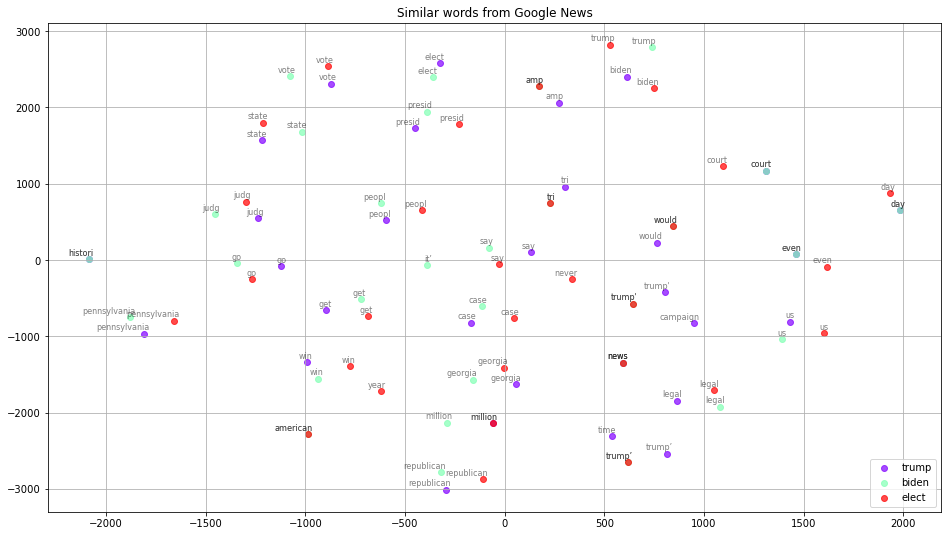

In [197]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

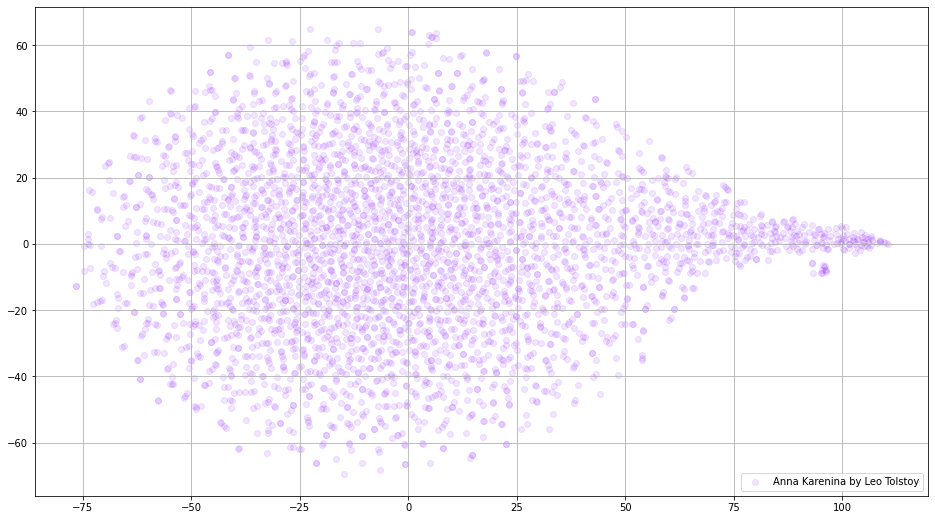

In [198]:
words_ak = []
embeddings_ak = []
for word in list(word2vec.wv.vocab):
    embeddings_ak.append(word2vec.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Anna Karenina by Leo Tolstoy', embeddings_ak_2d, a=0.1)

In [ ]:
import pickle

filename = 'glove2word2vec_model.sav'
model = pickle.load(open(filename, 'rb'))

def append_list(sim_words, words):
    
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

input_word = 'school'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []
    
for words in user_input:
    
        sim_words = model.most_similar(words, topn = 5)
        sim_words = append_list(sim_words, words)
            
        result_word.extend(sim_words)
    
similar_word = [word[0] for word in result_word]
similarity = [word[1] for word in result_word] 
similar_word.extend(user_input)
labels = [word[2] for word in result_word]
label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
color_map = [label_dict[x] for x in labels]

In [ ]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE

def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 0, iteration = 0, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]


    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()
    
display_tsne_scatterplot_3D(model, user_input, similar_word, labels, color_map, 5, 500, 10000)

In [199]:
# download scikit-learn
import sys
!{sys.executable} -m pip install scikit-learn

In [217]:

X = np.ndarray(shape=(len(tweet2vec),100), dtype=float, order='F')
for tweet_rep in tweet2vec:
    np.append(X, tweet_rep)
    
print(X)

[[1.17643134e-311 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.17643015e-311 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 2.44085575e-154 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.12011720e-085 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [6.01347206e-154 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


<class 'numpy.ndarray'>


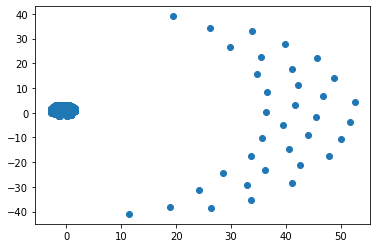

In [218]:
#X = word2vec.wv[word2vec.wv.vocab]
print(type(X))





tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

RQ 1A - Are you able to detect some subgroups within your tweets representation? Are you able to perform some clustering over the tweets and detect some topics within the conversation? How do you choose the best possible number of clusters?

RQ 1B - What are the 5 most relevant keywords in the tweets that are part of each cluster? To what extent these keywords characterize/separate well the clusters?
